# Representation Similarity Analysis
### with Orthogonal Procustes and Linear Centered Kernel Alignment

In [1]:
import os
import sys
from collections import defaultdict
from pathlib import Path

import albumentations as A
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, MultipleLocator
from torch.utils.data import DataLoader

# data loading
from datasets import UWFC, INat2021, TestDataset
from models import ResNet
from tasks.base import Task

sys.path.append("../../")

/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/venvs/SSL4PP/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# helper functions
def procrustes(A, B):
    """
    Computes Procrustes distance bewteen representations A and B
    """
    A_sq_frob = np.sum(A**2)
    B_sq_frob = np.sum(B**2)
    nuc = np.linalg.norm(A @ B.T, ord="nuc")  # O(p * p * n)
    return 1 - 0.5 * (A_sq_frob + B_sq_frob - 2 * nuc)


def lin_cka_dist(A, B):
    """
    Computes Linear CKA distance bewteen representations A and B
    """
    similarity = np.linalg.norm(B.T.dot(A), ord="fro") ** 2
    A_norm = np.linalg.norm(A.T.dot(A), ord="fro")
    B_norm = np.linalg.norm(B.T.dot(B), ord="fro")
    return similarity / (A_norm * B_norm)


def get_representations(model, dataloader, name):
    if os.path.exists(f"representations/{name}.npz"):
        representations = load_representations(f"representations/{name}.npz")
    else:
        reps = defaultdict(list)
        if torch.cuda.is_available():
            model.to("cuda")
        model.eval()
        for item in dataloader:
            image = item[0]
            out = model(image.to("cuda")) if torch.cuda.is_available() else model(image)
            for k, v in model.activations.items():
                layer_rep = v.cpu().numpy() if torch.cuda.is_available() else v.numpy()
                layer_rep = np.mean(layer_rep, axis=(2, 3))  # avg pool
                # layer_rep = layer_rep.reshape(layer_rep.shape[0], -1) # flatten feature maps; takes too much memory; freezes notebook
                reps[k].append(layer_rep)
        representations = [np.vstack(el) for el in reps.values()]
        os.makedirs("representations", exist_ok=True)
        np.savez_compressed(f"representations/{name}", *representations)
    return representations


def score_representations(rep1, rep2, save=True, name_prefix="rep1_rep2"):
    cka_result = None
    p_result = None
    if os.path.exists(f"results/{name_prefix}_procrustes.csv"):
        p_result = pd.read_csv(f"results/{name_prefix}_procrustes.csv", header=None)
    if os.path.exists(f"results/{name_prefix}_cka.csv"):
        cka_result = pd.read_csv(f"results/{name_prefix}_cka.csv", header=None)
    cache_loaded = cka_result is not None or p_result is not None
    if not cache_loaded:
        cka_result = np.empty((len(rep1), len(rep2)))
        p_result = np.empty((len(rep1), len(rep2)))

        for i, x in enumerate(rep1):
            for j, y in enumerate(rep2):
                # CKA expects centered matrices of dimension: num_examples x num_features
                # center each row
                x = x - np.mean(x, axis=0, keepdims=True)
                y = y - np.mean(y, axis=0, keepdims=True)

                cka_result[i][j] = lin_cka_dist(x, y)  # linear CKA

                # the procrustes metric expects a matrix of dimensions: num_features x num_examples
                # normalize each representation
                x_norm = x.T / np.linalg.norm(x.T, ord="fro")
                y_norm = y.T / np.linalg.norm(y.T, ord="fro")

                p_result[i][j] = procrustes(x_norm, y_norm)

        if save:
            os.makedirs("results", exist_ok=True)
            np.savetxt(f"results/{name_prefix}_cka.csv", cka_result, delimiter=",")
            np.savetxt(f"results/{name_prefix}_procrustes.csv", p_result, delimiter=",")

    return cka_result, p_result


def load_representations(filename):
    with open(filename, "rb") as f:
        a = np.load(filename, allow_pickle=True)
    return [a[f"arr_{i}"] for i in range(len(a))]


def plot_heatmap(result_mat):
    plt.figure(figsize=(11.69, 8.27))
    ax = sns.heatmap(result_mat, yticklabels=3, xticklabels=3, vmin=0, vmax=1)
    ax.invert_yaxis()
    return ax

In [3]:
transforms = A.Compose(
    [A.Resize(256, 256), A.CenterCrop(224, 224), A.Normalize(), ToTensorV2()]
)


def get_dataloader(dataset):
    return DataLoader(
        dataset, pin_memory=True, drop_last=False, batch_size=16, num_workers=2
    )


DATA_ROOT = Path("/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/data")

imagenet_dataset = TestDataset(
    str(DATA_ROOT.joinpath("ILSVRC2012", "test")),
    transform=transforms,
    sample_size=25000,
    seed=42,
)
inat_dataset = INat2021(
    str(DATA_ROOT.joinpath("inat-2021")),
    split="public_test",
    transform=transforms,
    sample_size=25000,
    sampling_method="uniform",
    seed=42,
)
uwfc_dataset = UWFC(
    str(DATA_ROOT.joinpath("uwfc_2020")),
    subset=3,
    split="test",
    transform=transforms,
    sample_size=25000,
    sampling_method="uniform",
    seed=42,
)

imagenet_loader = get_dataloader(imagenet_dataset)
inat_loader = get_dataloader(inat_dataset)
uwfc3_loader = get_dataloader(uwfc_dataset)

/gpfs/mdiops/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/tools/rep_similarity/../../datasets/utils.py:64: UserWarning: Samples do not have labels.
  warnings.warn("Samples do not have labels.")


Selected 25000 samples from dataset with 100000 images.


/gpfs/mdiops/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/tools/rep_similarity/../../datasets/inat_2021.py:206: UserWarning: The targets for this dataset have all been set to 0!
  warnings.warn(


Selected 25000 samples from dataset with 500000 images.
Selected 25000 samples from dataset with 40849 images.


In [4]:
#%%capture
# model loading

WEIGHT_DIR = Path("/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/output")

# load pretrained models
mocov2_inat_model = Task.load_pretrained_checkpoint(
    ResNet(50),
    str(
        WEIGHT_DIR.joinpath(
            "ContrastiveLearning/INat2021/mocov2_inat2021_95ep/2022-06-12_08-30-26/checkpoints/checkpoint_0095.pt"
        )
    ),
    replacement_key="",
)
densecl_inat_model = Task.load_pretrained_checkpoint(
    ResNet(50),
    str(
        WEIGHT_DIR.joinpath(
            "ContrastiveLearning/INat2021/densecl_inat2021_95ep/2022-06-08_15-27-39/checkpoints/checkpoint_0095.pt"
        )
    ),
    replacement_key="",
)
supervised_inat_model = Task.load_pretrained_checkpoint(
    ResNet(50, num_classes=10000),
    str(
        WEIGHT_DIR.joinpath(
            "ImageClassification/INat2021/inat2021_timm_rsb_a2_95ep_b256/last.pth.tar"
        )
    ),
    replacement_key="",
)

mocov2_imagenet_model = Task.load_pretrained_checkpoint(
    ResNet(50),
    str(
        WEIGHT_DIR.joinpath(
            "ContrastiveLearning/ImageNet/mocov2_imagenet/2022-05-28_15-14-11/checkpoints/checkpoint_0200.pt"
        )
    ),
    replacement_key="",
)
densecl_imagenet_model = Task.load_pretrained_checkpoint(
    ResNet(50),
    str(
        WEIGHT_DIR.joinpath(
            "DenseCL/ImageNet/densecl_imagenet/2022-04-30_21-11-13/checkpoints/checkpoint_0200.pt"
        )
    ),
    replacement_key="",
)
supervised_imagenet_model = Task.load_pretrained_checkpoint(
    ResNet(50, num_classes=1000),
    str(
        WEIGHT_DIR.joinpath(
            "ImageClassification/ImageNet/imagenet_timm_rsb_a2_200e_b256/last.pth.tar"
        )
    ),
    replacement_key="",
)

mocov2_uwfc3_model = Task.load_pretrained_checkpoint(
    ResNet(50),
    str(
        WEIGHT_DIR.joinpath(
            "ContrastiveLearning/UWFC/mocov2_uwfc_3_1668ep/2022-08-31_16-25-52/checkpoints/latest.pt"
        )
    ),
    replacement_key="",
)
densecl_uwfc3_model = Task.load_pretrained_checkpoint(
    ResNet(50),
    str(
        WEIGHT_DIR.joinpath(
            "ContrastiveLearning/UWFC/densecl_uwfc3_1668ep/2022-09-03_16-10-40/checkpoints/latest.pt"
        )
    ),
    replacement_key="",
)
supervised_uwfc3_model = Task.load_pretrained_checkpoint(
    ResNet(50, num_classes=5),
    str(WEIGHT_DIR.joinpath("ImageClassification/UWFC/uwfc3_1668ep/last.pth.tar")),
    replacement_key="",
)

Loading pretrained checkpoint: '/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/output/ContrastiveLearning/INat2021/mocov2_inat2021_95ep/2022-06-12_08-30-26/checkpoints/checkpoint_0095.pt'
Missing keys ['fc.weight', 'fc.bias']

Unexpected keys []
Loaded pre-trained model '/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/output/ContrastiveLearning/INat2021/mocov2_inat2021_95ep/2022-06-12_08-30-26/checkpoints/checkpoint_0095.pt'
Loading pretrained checkpoint: '/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/output/ContrastiveLearning/INat2021/densecl_inat2021_95ep/2022-06-08_15-27-39/checkpoints/checkpoint_0095.pt'
Missing keys ['fc.weight', 'fc.bias']

Unexpected keys []
Loaded pre-trained model '/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/output/ContrastiveLearning/INat2021/densecl_inat2021_95ep/2022-06-08_15-27-39/checkpoints/checkpoint_0095.pt'
Loading pretrained checkpoint: '/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/SSL4PP/output/ImageClassi

In [5]:
supervised_imagenet_benchmark = Task.load_pretrained_checkpoint(
    ResNet(50),
    "https://download.pytorch.org/models/resnet50-0676ba61.pth",
    replacement_key="",
)
densecl_imagenet_benchmark = Task.load_pretrained_checkpoint(
    ResNet(50),
    "https://cloudstor.aarnet.edu.au/plus/s/hdAg5RYm8NNM2QP/download",
    replacement_key="",
)
mocov2_imagenet_benchmark = Task.load_pretrained_checkpoint(
    ResNet(50),
    "https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_200ep/moco_v2_200ep_pretrain.pth.tar",
    replacement_key="",
)

Loading pretrained checkpoint: 'https://download.pytorch.org/models/resnet50-0676ba61.pth'
Missing keys []

Unexpected keys []
Loaded pre-trained model 'https://download.pytorch.org/models/resnet50-0676ba61.pth'
Loading pretrained checkpoint: 'https://cloudstor.aarnet.edu.au/plus/s/hdAg5RYm8NNM2QP/download'
Missing keys ['fc.weight', 'fc.bias']

Unexpected keys []
Loaded pre-trained model 'https://cloudstor.aarnet.edu.au/plus/s/hdAg5RYm8NNM2QP/download'
Loading pretrained checkpoint: 'https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_200ep/moco_v2_200ep_pretrain.pth.tar'
Missing keys ['fc.weight', 'fc.bias']

Unexpected keys ['encoder_q.fc.0.weight', 'encoder_q.fc.0.bias', 'encoder_q.fc.2.weight', 'encoder_q.fc.2.bias']
Loaded pre-trained model 'https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_200ep/moco_v2_200ep_pretrain.pth.tar'


In [6]:
mocov2_inat_reps = get_representations(mocov2_inat_model, inat_loader, "mocov2_inat")
densecl_inat_reps = get_representations(densecl_inat_model, inat_loader, "densecl_inat")
supervised_inat_reps = get_representations(
    supervised_inat_model, inat_loader, "supervised_inat"
)

In [7]:
md_inat_cka, md_inat_p = score_representations(
    mocov2_inat_reps, densecl_inat_reps, save=True, name_prefix="moco_densecl_inat"
)

In [8]:
ms_inat_cka, ms_inat_p = score_representations(
    mocov2_inat_reps,
    supervised_inat_reps,
    save=True,
    name_prefix="moco_supervised_inat",
)

In [9]:
ds_inat_cka, ds_inat_p = score_representations(
    densecl_inat_reps,
    supervised_inat_reps,
    save=True,
    name_prefix="densecl_supervised_inat",
)

In [10]:
mocov2_imagenet_reps = get_representations(
    mocov2_imagenet_model, imagenet_loader, "mocov2_imagenet"
)
densecl_imagenet_reps = get_representations(
    densecl_imagenet_model, imagenet_loader, "densecl_imagenet"
)
supervised_imagenet_reps = get_representations(
    supervised_imagenet_model, imagenet_loader, "supervised_imagenet"
)

mocov2_benchmark_reps = get_representations(
    mocov2_imagenet_benchmark, imagenet_loader, "mocov2_imagenet_benchmark"
)
densecl_benchmark_reps = get_representations(
    densecl_imagenet_benchmark, imagenet_loader, "densecl_imagenet_benchmark"
)
supervised_benchmark_reps = get_representations(
    densecl_imagenet_benchmark, imagenet_loader, "supervised_imagenet_benchmark"
)

/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/venvs/SSL4PP/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
md_imagenet_cka, md_imagenet_p = score_representations(
    mocov2_imagenet_reps,
    densecl_imagenet_reps,
    save=True,
    name_prefix="moco_densecl_imagenet",
)
md_imagenet_benchmark_cka, md_imagenet_benchmark_p = score_representations(
    mocov2_benchmark_reps,
    densecl_benchmark_reps,
    save=True,
    name_prefix="moco_densecl_imagenet_benchmark",
)

In [12]:
ms_imagenet_cka, ms_imagenet_p = score_representations(
    mocov2_imagenet_reps,
    supervised_imagenet_reps,
    save=True,
    name_prefix="moco_supervised_imagenet",
)
ms_imagenet_benchmark_cka, ms_imagenet_benchmark_p = score_representations(
    mocov2_benchmark_reps,
    supervised_benchmark_reps,
    save=True,
    name_prefix="moco_supervised_imagenet_benchmark",
)

In [13]:
ds_imagenet_cka, ds_imagenet_p = score_representations(
    densecl_imagenet_reps,
    supervised_imagenet_reps,
    save=True,
    name_prefix="densecl_supervised_imagenet",
)
ds_imagenet_benchmark_cka, ds_imagenet_benchmark_p = score_representations(
    densecl_benchmark_reps,
    supervised_benchmark_reps,
    save=True,
    name_prefix="densecl_supervised_imagenet_benchmark",
)

In [14]:
mocov2_uwfc3_reps = get_representations(
    mocov2_uwfc3_model, uwfc3_loader, "mocov2_uwfc3"
)
densecl_uwfc3_reps = get_representations(
    densecl_uwfc3_model, uwfc3_loader, "densecl_uwfc3"
)
supervised_uwfc3_reps = get_representations(
    supervised_uwfc3_model, uwfc3_loader, "supervised_uwfc3"
)

In [15]:
md_uwfc3_cka, md_uwfc3_p = score_representations(
    mocov2_uwfc3_reps, densecl_uwfc3_reps, save=True, name_prefix="moco_densecl_uwfc3"
)

In [16]:
ms_uwfc3_cka, ms_uwfc3_p = score_representations(
    mocov2_uwfc3_reps,
    supervised_uwfc3_reps,
    save=True,
    name_prefix="moco_supervised_uwfc3",
)

In [17]:
ds_uwfc3_cka, ds_uwfc3_p = score_representations(
    densecl_uwfc3_reps,
    supervised_uwfc3_reps,
    save=True,
    name_prefix="densecl_supervised_uwfc3",
)

#### Plotting

In [18]:
# settings from: https://towardsdatascience.com/making-publication-quality-figures-in-python-part-i-fig-and-axes-d86c3903ad9b
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 28
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["figure.figsize"] = (11.69, 8.27)
mpl.rcParams["figure.autolayout"] = True

/tmp/ipykernel_57941/1400703165.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../assets/procrustes_similarity.svg", format="svg", dpi=1000, transparent=True, bbox_inches="tight")
/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/venvs/SSL4PP/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


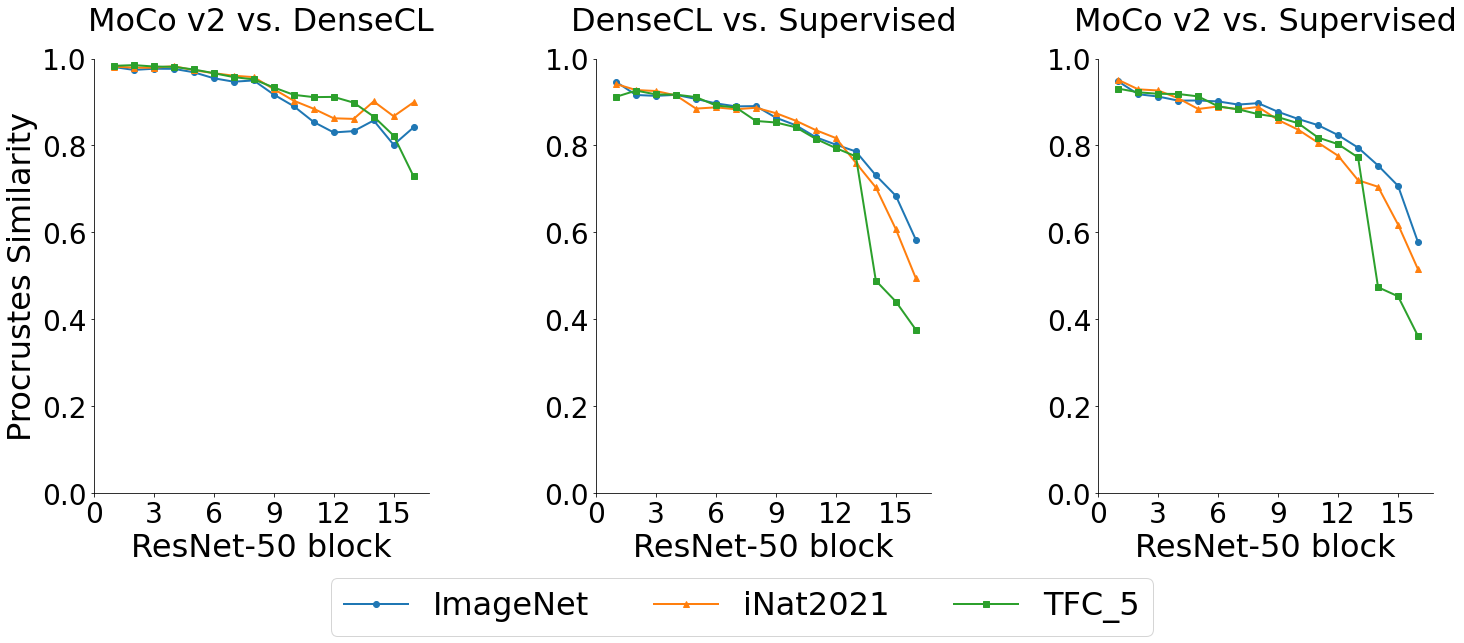

In [55]:
# plot diagonal values of procustes similarity
NUM_BLOCKS = 16
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharex=True, figsize=(24, 8), gridspec_kw={"wspace": 0.5}
)
# fig.suptitle("Representation Similarity Analysis with Procrustes Similarity", fontweight='bold', y=1.06)

p1 = axes[0].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(md_imagenet_p),
    "o-",
    label="MoCov2 vs. DenseCL ImageNet",
)
p2 = axes[0].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(md_inat_p),
    "^-",
    label="MoCov2 vs. DenseCL iNat2021",
)
p3 = axes[0].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(md_uwfc3_p),
    "s-",
    label="MoCov2 vs. DenseCL TFC_5",
)
axes[0].set_title("MoCo v2 vs. DenseCL", y=1.05, fontsize=32)
axes[0].set_ylabel("Procrustes Similarity", fontsize=32)

axes[1].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ds_imagenet_p),
    "o-",
    label="DenseCL vs Supervised ImageNet",
)
axes[1].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ds_inat_p),
    "^-",
    label="DenseCL vs Supervised iNat2021",
)
axes[1].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ds_uwfc3_p),
    "s-",
    label="DenseCL vs. Supervised TFC_5",
)
axes[1].set_title("DenseCL vs. Supervised", y=1.05, fontsize=32)

axes[2].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ms_imagenet_p),
    "o-",
    label="MoCov2 vs. Supervised ImageNet",
)
axes[2].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ms_inat_p),
    "^-",
    label="MoCov2 vs. Supervised iNat2021",
)
axes[2].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ms_uwfc3_p),
    "s-",
    label="MoCov2 vs. Supervised TFC_5",
)
axes[2].set_title("MoCo v2 vs. Supervised", y=1.05, fontsize=32)

for ax in axes:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("ResNet-50 block", fontsize=32)
    ax.set_xticks(np.arange(0.0, 17, 3))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))

fig.legend(
    handles=[p1[0], p2[0], p3[0]],
    labels=["ImageNet", "iNat2021", "TFC_5"],
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.15),
    fontsize=32,
)
# fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.15))

plt.savefig(
    "../../assets/procrustes_similarity.svg",
    format="svg",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
)
plt.show()

/tmp/ipykernel_57941/2568199664.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../assets/linear_CKA.svg", format="svg", dpi=1000, transparent=True, bbox_inches="tight")
/scratch/p2irc/p2irc_plotvision/flagship3/gmi672/venvs/SSL4PP/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


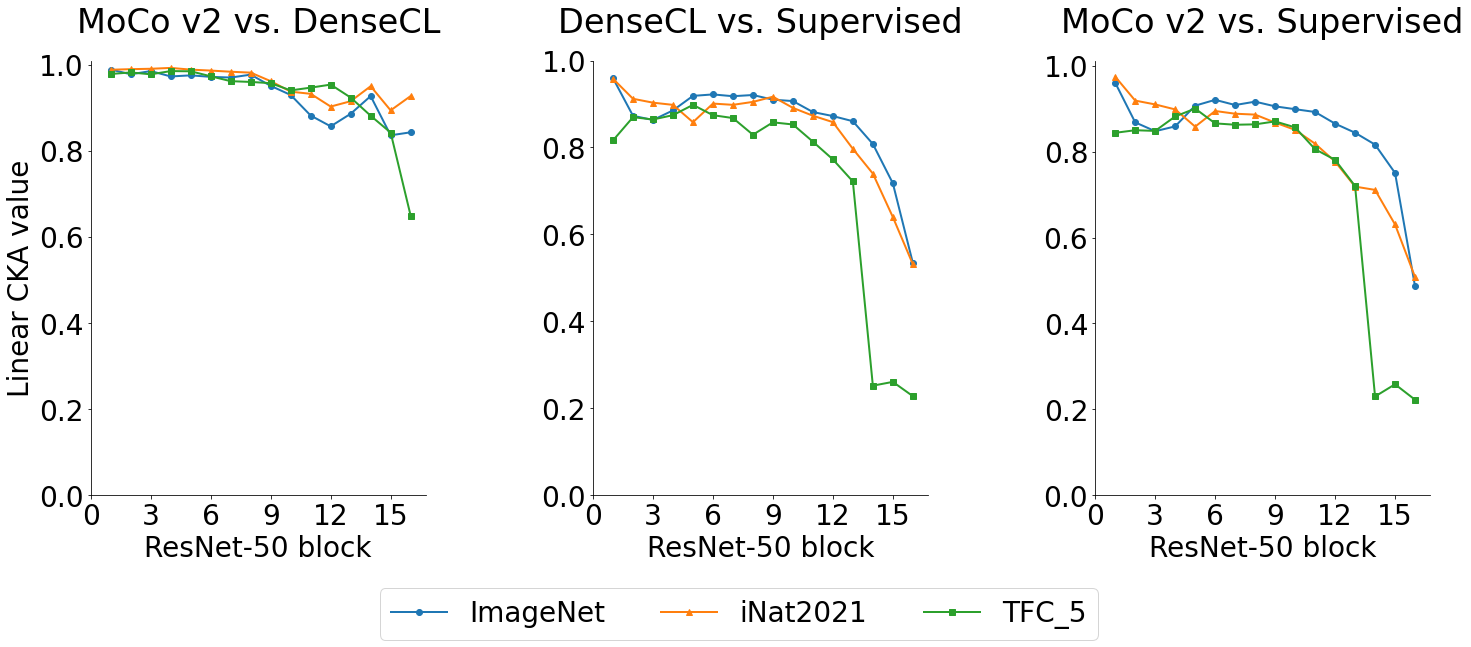

In [56]:
# plot diagonal values of linear CKA
NUM_BLOCKS = 16
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharex=True, figsize=(24, 8), gridspec_kw={"wspace": 0.5}
)

p1 = axes[0].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(md_imagenet_cka),
    "o-",
    label="MoCov2 vs. DenseCL ImageNet",
)
p2 = axes[0].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(md_inat_cka),
    "^-",
    label="MoCov2 vs. DenseCL iNat2021",
)
p3 = axes[0].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(md_uwfc3_cka),
    "s-",
    label="MoCov2 vs. DenseCL TFC_5",
)
axes[0].set_title("MoCo v2 vs. DenseCL", y=1.05)
axes[0].set_ylabel("Linear CKA value")

axes[1].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ds_imagenet_cka),
    "o-",
    label="DenseCL vs Supervised ImageNet",
)
axes[1].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ds_inat_cka),
    "^-",
    label="DenseCL vs Supervised iNat2021",
)
axes[1].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ds_uwfc3_cka),
    "s-",
    label="DenseCL vs. Supervised TFC_5",
)
axes[1].set_title("DenseCL vs. Supervised", y=1.05)

axes[2].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ms_imagenet_cka),
    "o-",
    label="MoCov2 vs. Supervised ImageNet",
)
axes[2].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ms_inat_cka),
    "^-",
    label="MoCov2 vs. Supervised iNat2021",
)
axes[2].plot(
    range(1, NUM_BLOCKS + 1),
    np.diagonal(ms_uwfc3_cka),
    "s-",
    label="MoCov2 vs. Supervised TFC_5",
)
axes[2].set_title("MoCo v2 vs. Supervised", y=1.05)

for ax in axes:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("ResNet-50 block")
    ax.set_xticks(np.arange(0.0, 17, 3))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))

fig.legend(
    handles=[p1[0], p2[0], p3[0]],
    labels=["ImageNet", "iNat2021", "TFC_5"],
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.15),
)

plt.savefig(
    "../../assets/linear_CKA.svg",
    format="svg",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
)
plt.show()

In [ ]:
mpl.rcParams["font.size"] = 20

In [ ]:
# plot full matrix as heatmap

fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(20, 20), gridspec_kw={"wspace": 0.5, "hspace": 0.5}
)

sns.heatmap(
    md_imagenet_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[0][0],
    square=True,
    cbar=False,
)
axes[0][0].set_ylabel("Block of MoCo v2 ImageNet")
axes[0][0].set_xlabel("Block of DenseCL ImageNet")

sns.heatmap(
    ms_imagenet_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[0][1],
    square=True,
    cbar=False,
)
axes[0][1].set_ylabel("Block of MoCo v2 ImageNet")
axes[0][1].set_xlabel("Block of Supervised ImageNet")

sns.heatmap(
    ds_imagenet_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[0][2],
    square=True,
)
axes[0][2].set_ylabel("Block of DenseCL ImageNet")
axes[0][2].set_xlabel("Block of Supervised ImageNet")

sns.heatmap(
    md_inat_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[1][0],
    square=True,
    cbar=False,
)
axes[1][0].set_ylabel("Block of MoCo v2 iNat2021")
axes[1][0].set_xlabel("Block of DenseCL iNat2021")

sns.heatmap(
    ms_inat_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[1][1],
    square=True,
    cbar=False,
)
axes[1][1].set_ylabel("Block of MoCo v2 iNat2021")
axes[1][1].set_xlabel("Block of Supervised iNat2021")

sns.heatmap(
    ds_inat_p, yticklabels=3, xticklabels=3, vmin=0, vmax=1, ax=axes[1][2], square=True
)
axes[1][2].set_ylabel("Block of DenseCL iNat2021")
axes[1][2].set_xlabel("Block of Supervised iNat2021")

sns.heatmap(
    md_uwfc3_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[2][0],
    square=True,
    cbar=False,
)
axes[2][0].set_ylabel("Block of MoCo v2 TFC_5")
axes[2][0].set_xlabel("Block of DenseCL TFC_5")

sns.heatmap(
    ms_uwfc3_p,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[2][1],
    square=True,
    cbar=False,
)
axes[2][1].set_ylabel("Block of MoCo v2 TFC_5")
axes[2][1].set_xlabel("Block of Supervised TFC_5")

sns.heatmap(
    ds_uwfc3_p, yticklabels=3, xticklabels=3, vmin=0, vmax=1, ax=axes[2][2], square=True
)
axes[2][2].set_ylabel("Block of DenseCL TFC_5")
axes[2][2].set_xlabel("Block of Supervised TFC_5")

for axs in axes:
    for ax in axs:
        ax.invert_yaxis()

plt.savefig(
    "../../assets/procrustes_similarity_full.svg",
    format="svg",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
)
plt.show()

In [ ]:
# plot full matrix as heatmap

fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(20, 20), gridspec_kw={"wspace": 0.5, "hspace": 0.5}
)

sns.heatmap(
    md_imagenet_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[0][0],
    square=True,
    cbar=False,
)
axes[0][0].set_ylabel("Block of MoCo v2 ImageNet")
axes[0][0].set_xlabel("Block of DenseCL ImageNet")

sns.heatmap(
    ms_imagenet_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[0][1],
    square=True,
    cbar=False,
)
axes[0][1].set_ylabel("Block of MoCo v2 ImageNet")
axes[0][1].set_xlabel("Block of Supervised ImageNet")

sns.heatmap(
    ds_imagenet_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[0][2],
    square=True,
)
axes[0][2].set_ylabel("Block of DenseCL ImageNet")
axes[0][2].set_xlabel("Block of Supervised ImageNet")

sns.heatmap(
    md_inat_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[1][0],
    square=True,
    cbar=False,
)
axes[1][0].set_ylabel("Block of MoCo v2 iNat2021")
axes[1][0].set_xlabel("Block of DenseCL iNat2021")

sns.heatmap(
    ms_inat_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[1][1],
    square=True,
    cbar=False,
)
axes[1][1].set_ylabel("Block of MoCo v2 iNat2021")
axes[1][1].set_xlabel("Block of Supervised iNat2021")

sns.heatmap(
    ds_inat_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[1][2],
    square=True,
)
axes[1][2].set_ylabel("Block of DenseCL iNat2021")
axes[1][2].set_xlabel("Block of Supervised iNat2021")

sns.heatmap(
    md_uwfc3_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[2][0],
    square=True,
    cbar=False,
)
axes[2][0].set_ylabel("Block of MoCo v2 TFC_5")
axes[2][0].set_xlabel("Block of DenseCL TFC_5")

sns.heatmap(
    ms_uwfc3_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[2][1],
    square=True,
    cbar=False,
)
axes[2][1].set_ylabel("Block of MoCo v2 TFC_5")
axes[2][1].set_xlabel("Block of Supervised TFC_5")

sns.heatmap(
    ds_uwfc3_cka,
    yticklabels=3,
    xticklabels=3,
    vmin=0,
    vmax=1,
    ax=axes[2][2],
    square=True,
)
axes[2][2].set_ylabel("Block of DenseCL TFC_5")
axes[2][2].set_xlabel("Block of Supervised TFC_5")

for axs in axes:
    for ax in axs:
        ax.invert_yaxis()

plt.savefig(
    "../../assets/linear_CKA_full.svg",
    format="svg",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
)
plt.show()